In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers

# Kshitiz Bhargava 21BCE2067

In [2]:
# Define the environment: Simple Grid World
class SimpleGridWorld:
    def __init__(self, grid_size=10, goal_position=9, move_penalty=-0.1):
        self.grid_size = grid_size
        self.goal_position = goal_position
        self.move_penalty = move_penalty
        self.reset()
        
    def reset(self):
        """Resets the environment to the starting state"""
        self.state = 0  # Starting at position 0
        return self.state
    
    def step(self, action):
        """Applies the action and returns the next state, reward, and done flag"""
        if action == 0:  # Move left
            self.state = max(0, self.state - 1)
        elif action == 1:  # Move right
            self.state = min(self.grid_size - 1, self.state + 1)
        
        # Reward function
        if self.state == self.goal_position:
            reward = 1  # Goal reached
            done = True
        else:
            reward = self.move_penalty  # Penalize for each move
            done = False
        
        return self.state, reward, done

# Kshitiz Bhargava 21BCE2067

In [3]:
# 1. Q-Learning Algorithm
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, episodes=1000):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.episodes = episodes
        
        # Initialize Q-table
        self.q_table = np.zeros((env.grid_size, 2))  # 2 actions: 0 (left), 1 (right)
    
    def choose_action(self, state):
        """Choose an action based on epsilon-greedy strategy"""
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(2)  # Random action (exploration)
        else:
            return np.argmax(self.q_table[state])  # Best action (exploitation)
    
    def train(self):
        rewards_per_episode = []
        
        for episode in range(self.episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                
                # Q-learning update rule
                self.q_table[state, action] = self.q_table[state, action] + self.alpha * (
                    reward + self.gamma * np.max(self.q_table[next_state]) - self.q_table[state, action]
                )
                
                total_reward += reward
                state = next_state
                
            rewards_per_episode.append(total_reward)
        
        return rewards_per_episode

# Kshitiz Bhargava 21BCE2067

In [4]:
# 2. SARSA Algorithm
class SARSAAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, episodes=1000):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.episodes = episodes
        
        # Initialize Q-table
        self.q_table = np.zeros((env.grid_size, 2))  # 2 actions: 0 (left), 1 (right)
    
    def choose_action(self, state):
        """Choose an action based on epsilon-greedy strategy"""
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(2)  # Random action (exploration)
        else:
            return np.argmax(self.q_table[state])  # Best action (exploitation)
    
    def train(self):
        rewards_per_episode = []
        
        for episode in range(self.episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            done = False
            total_reward = 0
            
            while not done:
                next_state, reward, done = self.env.step(action)
                next_action = self.choose_action(next_state)
                
                # SARSA update rule
                self.q_table[state, action] = self.q_table[state, action] + self.alpha * (
                    reward + self.gamma * self.q_table[next_state, next_action] - self.q_table[state, action]
                )
                
                total_reward += reward
                state, action = next_state, next_action
                
            rewards_per_episode.append(total_reward)
        
        return rewards_per_episode
    
# Kshitiz Bhargava 21BCE2067

In [5]:
# 3. Policy Gradient Algorithm
class PolicyGradientAgent:
    def __init__(self, env, gamma=0.99, episodes=1000, learning_rate=0.01):
        self.env = env
        self.gamma = gamma
        self.episodes = episodes
        self.learning_rate = learning_rate
        
        # Initialize the neural network for policy
        self.model = tf.keras.Sequential([
            layers.Dense(24, activation='relu', input_dim=env.grid_size),  # Adjusted for input_dim
            layers.Dense(env.grid_size, activation='softmax')  # Softmax for action probabilities
        ])
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    
    def choose_action(self, state):
        # Convert state to one-hot encoding
        one_hot_state = np.zeros(self.env.grid_size)
        one_hot_state[state] = 1  # Set the corresponding position to 1
        
        # Reshape state to match input shape of neural network
        one_hot_state = np.reshape(one_hot_state, [1, -1])  # (1, grid_size)
        
        # Get action probabilities from the model
        probabilities = self.model(one_hot_state)
        
        # Sample action based on the probabilities
        action = np.random.choice(self.env.grid_size, p=probabilities.numpy()[0])
        return action
    
    def compute_discounted_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        cumulative = 0
        for t in reversed(range(len(rewards))):
            cumulative = rewards[t] + self.gamma * cumulative
            discounted_rewards[t] = cumulative
        return discounted_rewards
    
    def train(self):
        rewards_per_episode = []
        
        for episode in range(self.episodes):
            state = self.env.reset()
            done = False
            episode_rewards = []
            states = []
            actions = []
            
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                
                episode_rewards.append(reward)
                states.append(state)
                actions.append(action)
                
                state = next_state
            
            discounted_rewards = self.compute_discounted_rewards(episode_rewards)
            
            with tf.GradientTape() as tape:
                total_loss = 0
                for state, action, reward in zip(states, actions, discounted_rewards):
                    one_hot_state = np.zeros(self.env.grid_size)
                    one_hot_state[state] = 1  # One-hot encode the state
                    one_hot_state = np.reshape(one_hot_state, [1, -1])  # (1, grid_size)
                    
                    probabilities = self.model(one_hot_state)
                    action_prob = probabilities[0, action]
                    loss = -tf.math.log(action_prob) * reward  # Policy gradient loss
                    total_loss += loss
                total_loss /= len(states)
            
            grads = tape.gradient(total_loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

            rewards_per_episode.append(sum(episode_rewards))
        
        return rewards_per_episode
    
# Kshitiz Bhargava 21BCE2067

In [6]:
# 4. Deep Q-learning (DQN) Algorithm
class DQNAgent:
    def __init__(self, env, gamma=0.99, alpha=0.001, epsilon=0.1, episodes=1000, batch_size=64, memory_size=10000):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.episodes = episodes
        self.batch_size = batch_size
        self.memory_size = memory_size
        
        # Experience replay buffer
        self.memory = []
        
        # Initialize Q-network and target network
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.target_model.set_weights(self.model.get_weights())
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.alpha)
    
    def build_model(self):
        model = tf.keras.Sequential([
            layers.Dense(24, activation='relu', input_shape=(self.env.grid_size,)),  # Adjusted for one-hot encoding
            layers.Dense(24, activation='relu'),
            layers.Dense(self.env.grid_size, activation='linear')  # Output layer for Q-values
        ])
        return model
    
    def choose_action(self, state):
        # One-hot encode the state
        one_hot_state = np.zeros(self.env.grid_size)
        one_hot_state[state] = 1  # Set the corresponding position to 1
        
        # Reshape state to match input shape of neural network
        one_hot_state = np.reshape(one_hot_state, [1, -1])  # (1, grid_size)
        
        # Get Q-values from the model
        q_values = self.model(one_hot_state)
        
        # Choose the action with the highest Q-value (greedy policy)
        return np.argmax(q_values)
    
    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)
    
    def sample_batch(self):
        batch = np.random.choice(len(self.memory), self.batch_size, replace=False)
        batch_data = [self.memory[i] for i in batch]
        states, actions, rewards, next_states, dones = zip(*batch_data)
        return np.array(states), actions, rewards, np.array(next_states), np.array(dones)  # Ensure dones is an array
    
    def train(self):
        rewards_per_episode = []
        
        for episode in range(self.episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                
                self.store_experience(state, action, reward, next_state, done)
                
                if len(self.memory) >= self.batch_size:
                    states, actions, rewards_batch, next_states, dones = self.sample_batch()
                    
                    # One-hot encode states and next states
                    one_hot_states = np.zeros((self.batch_size, self.env.grid_size))
                    one_hot_next_states = np.zeros((self.batch_size, self.env.grid_size))
                    
                    for i, state in enumerate(states):
                        one_hot_states[i, state] = 1  # One-hot encode the state
                    for i, next_state in enumerate(next_states):
                        one_hot_next_states[i, next_state] = 1  # One-hot encode the next state
                    
                    # Q-learning update rule
                    next_q_values = self.target_model(one_hot_next_states)
                    target_q_values = rewards_batch + self.gamma * np.max(next_q_values, axis=1) * (1 - dones)
                    
                    with tf.GradientTape() as tape:
                        q_values = self.model(one_hot_states)
                        q_value = tf.gather(q_values, actions, axis=1, batch_dims=1)
                        loss = tf.reduce_mean((target_q_values - q_value) ** 2)
                    
                    grads = tape.gradient(loss, self.model.trainable_variables)
                    self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
                    
                    # Periodically update target model
                    if episode % 10 == 0:
                        self.target_model.set_weights(self.model.get_weights())
                
                total_reward += reward
                state = next_state
                
            rewards_per_episode.append(total_reward)
        
        return rewards_per_episode
    
# Kshitiz Bhargava 21BCE2067

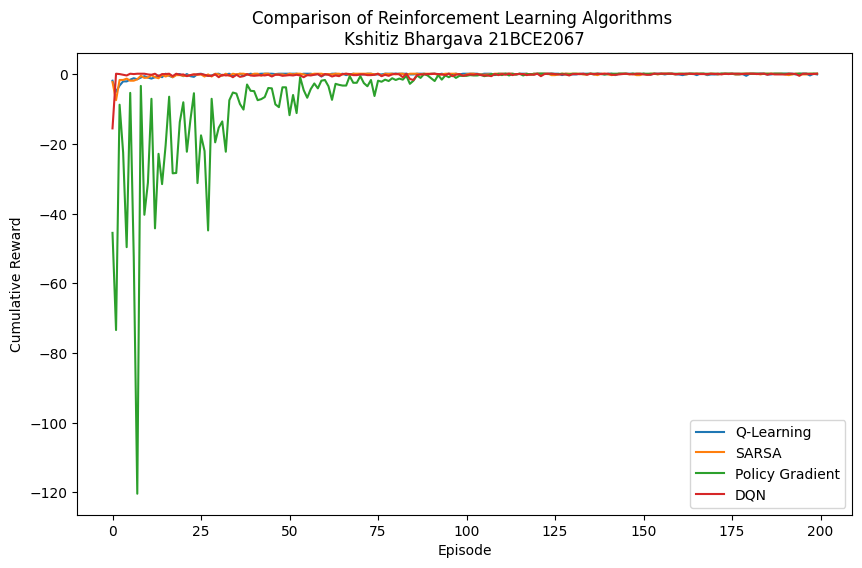

In [8]:
# Main execution: Initialize environment and agents
if __name__ == "__main__":
    # Create environment
    env = SimpleGridWorld()

    # Initialize agents
    agents = {
        "Q-Learning": QLearningAgent(env, episodes=200),
        "SARSA": SARSAAgent(env, episodes=200),
        "Policy Gradient": PolicyGradientAgent(env, episodes=200),
        "DQN": DQNAgent(env, episodes=200)
    }

    rewards = {}

    # Train each agent and store their rewards
    for agent_name, agent in agents.items():
        rewards[agent_name] = agent.train()

    # Plot the cumulative rewards for all agents on the same graph
    plt.figure(figsize=(10, 6))
    for agent_name, agent_rewards in rewards.items():
        plt.plot(agent_rewards, label=agent_name)

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Comparison of Reinforcement Learning Algorithms \nKshitiz Bhargava 21BCE2067')
    plt.legend()
    plt.show()

# Kshitiz Bhargava 21BCE2067